In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import sklearn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from datetime import datetime
from torch.nn.functional import mse_loss
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from utils_pp import replace_cell_names_with_id
from utils_pp import Encoder
from utils_pp import EarlyStopper
from utils_pp import Dataset_from_pd
from utils_pp import AE_DNN
from utils_pp import pcc_fn
from utils_pp import plot_from_df
from torch.utils.tensorboard import SummaryWriter
%load_ext autoreload
%autoreload 2

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [2]:
columns = ["cell_line", "drugA_name", "drugB_name", "drugA_conc", "drugB_conc", "target"]
data_train = pd.read_csv("../data_raw/oneil.csv", usecols=(1,2,3,4,5,12)).iloc[:,[0,1,3,2,4,5]].set_axis(columns, axis=1)
data_test = pd.read_csv("../data/test_yosua.csv").set_axis(columns + ["std"], axis=1).convert_dtypes()
data_train = replace_cell_names_with_id(dataframe=data_train, mapping_file="../data/mappingccl.csv")
data_test = replace_cell_names_with_id(dataframe=data_test, mapping_file="../data/mappingccl.csv")
drug_data = pd.read_pickle("../data/drug_data.pkl.compress", compression="gzip")
cell_data = pd.read_pickle("../data/cell_line_data.pkl.compress", compression="gzip")
data_train = data_train[data_train.cell_line.isin(cell_data.index)]

df_train, df_val = train_test_split(data_train, test_size=0.2, shuffle=True, random_state=42)
df_test = data_test

cell_data = cell_data[cell_data.index.isin(pd.concat([df_train.cell_line, df_test.cell_line]))]
drug_data = drug_data[drug_data.index.isin(pd.concat([df_train.drugA_name, df_train.drugB_name,df_test.drugA_name, df_test.drugB_name]))]
print("oneil", df_train.memory_usage().sum()/1e6, df_train.shape,"\n", df_train.dtypes)
print("drug_feat", drug_data.memory_usage().sum()/1e6, drug_data.shape)
print("cell_feat", cell_data.memory_usage().sum()/1e6, cell_data.shape)
DRUG_LENGTH = drug_data.shape[1]
CELL_LENGTH = cell_data.shape[1]
EMBED_SIZE = 770

oneil 13.13536 (234560, 6) 
 cell_line      object
drugA_name     object
drugB_name     object
drugA_conc    float64
drugB_conc    float64
target        float64
dtype: object
drug_feat 0.427236 (42, 2412)
cell_feat 0.686136 (32, 5011)


In [18]:
model = AE_DNN([770,256,256,256, 128,128,128,64,64,64], DRUG_LENGTH, CELL_LENGTH)
model.load_state_dict(torch.load(r"C:\Users\antoi\ai-imbsl\ai-imbsl\models\ae_dnn_model_finetune.pt"))
model.eval()
model.to(device)

AE_DNN(
  (drug_encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=2412, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=512, out_features=512, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=512, out_features=256, bias=True)
    )
  )
  (cell_encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=5011, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=512, out_features=512, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=512, out_features=256, bias=True)
    )
  )
  (hidden): ModuleList(
    (0): Linear(in_features=770, out_features=256, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): Dropout(p=0.1, inplace=False)


C:\Users\antoi\AppData\Local\Temp\ipykernel_13864\3287754040.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,5,i+1)


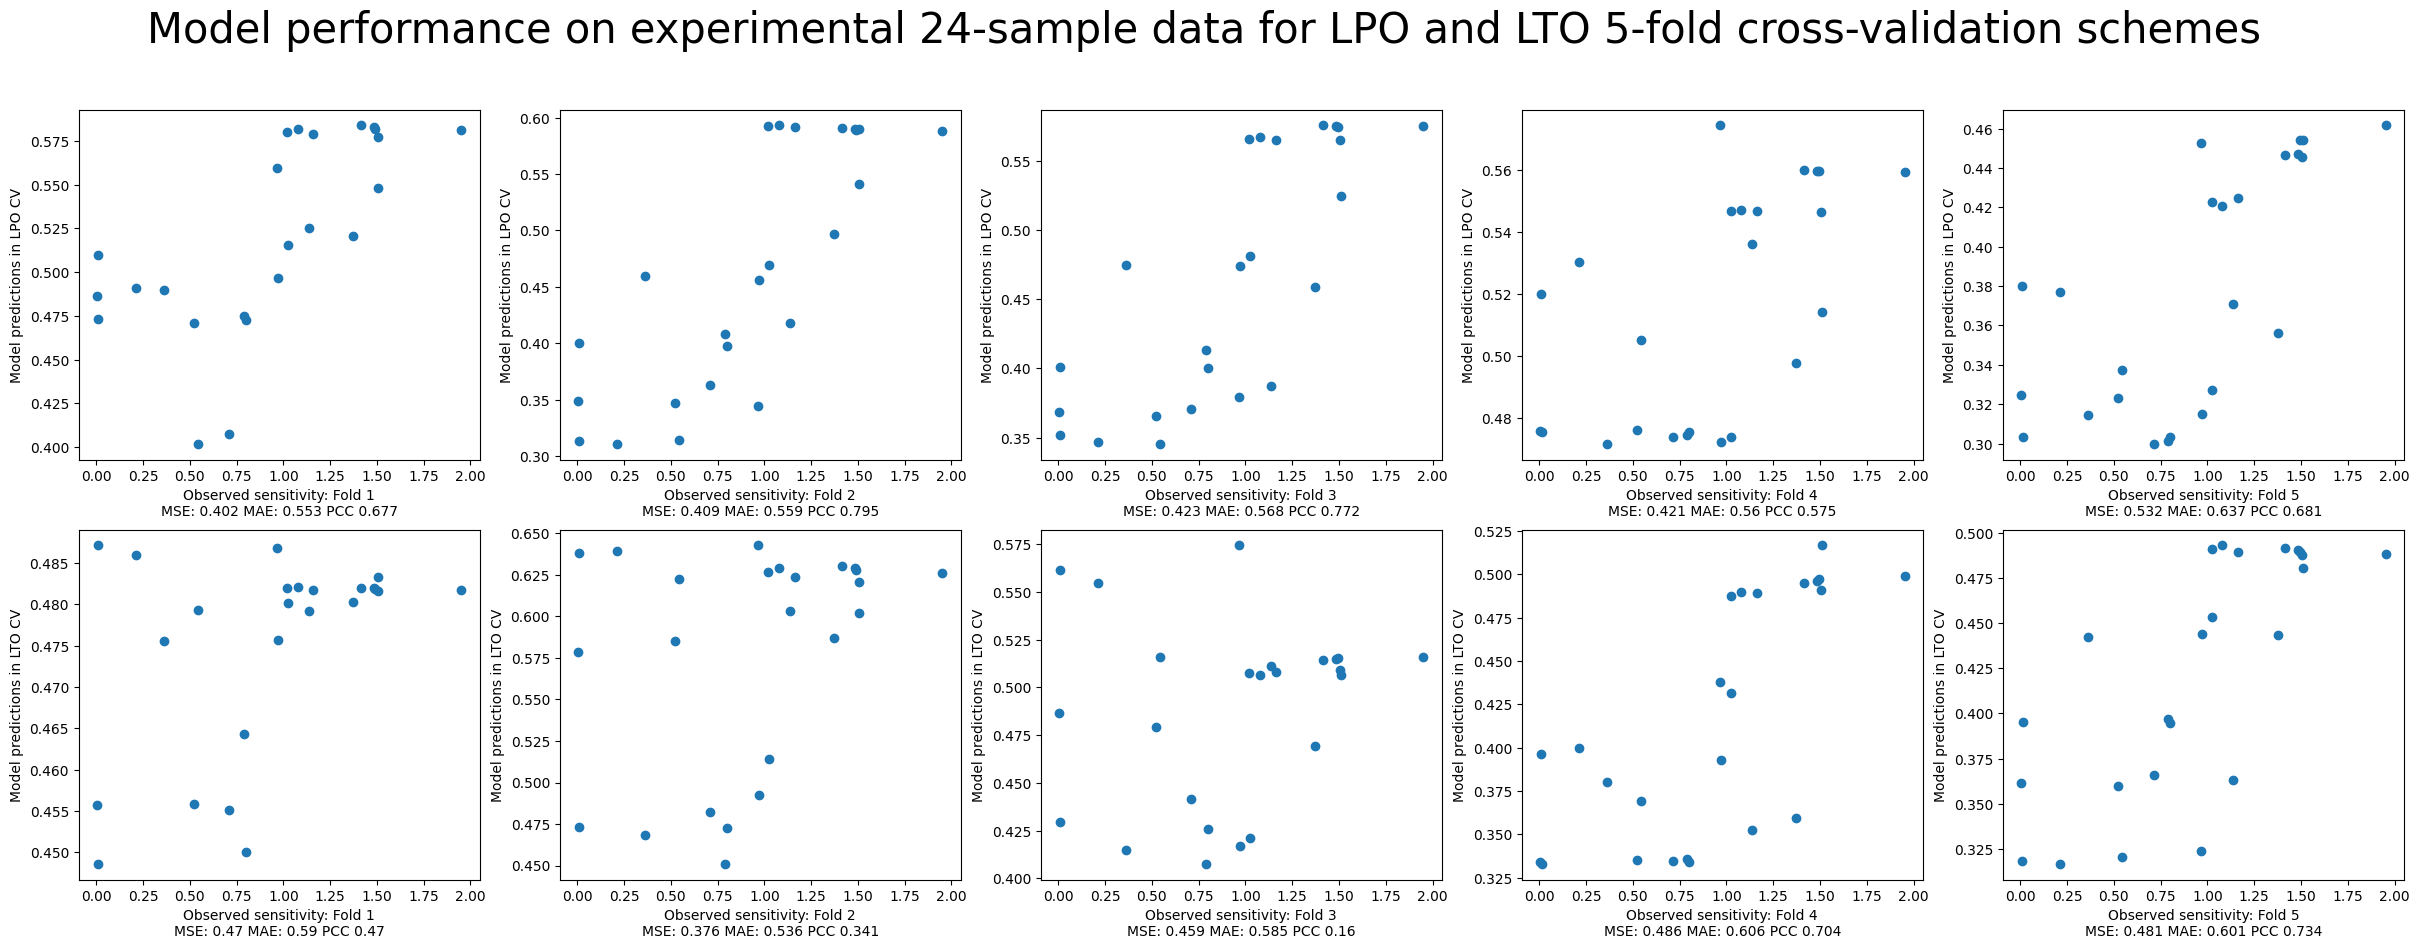

In [215]:
test_set  = Dataset_from_pd(df_test, drug_data, cell_data)
test_dl = DataLoader(test_set, batch_size=25)
loss_fn = torch.nn.MSELoss()
mae_fn = torch.nn.L1Loss()
with torch.no_grad():
    for i, data in enumerate(test_dl):
        inputs, labels = data
labels = labels.to("cpu").view(-1)

plt.subplots(figsize=(30, 10))

test_pair_records = np.load("test_pair_outputs.npy")
for i in range(5):
    outputs = test_pair_records[i].reshape(-1)
    outputs = torch.tensor(outputs)
    loss_test = round(loss_fn(outputs, labels).item(), 3)
    mae_test = round(mae_fn(outputs, labels).item(),3)
    pcc_test = round(pcc_fn(outputs, labels).item(),3)
    plt.subplot(2,5,i+1)
    plt.scatter(labels, outputs)
    plt.ylabel("Model predictions in LPO CV")
    plt.xlabel("Observed sensitivity: Fold {}\n".format(i+1) +"MSE: {} MAE: {} PCC {}".format(loss_test,mae_test,pcc_test))


test_triplet_records = np.load("test_triplet_outputs.npy")
for i in range(5):
    outputs = test_triplet_records[i].reshape(-1)
    outputs = torch.tensor(outputs)
    loss_test = round(loss_fn(outputs, labels).item(), 3)
    mae_test = round(mae_fn(outputs, labels).item(),3)
    pcc_test = round(pcc_fn(outputs, labels).item(),3)
    plt.subplot(2,5,i+1+5)
    plt.scatter(labels, outputs)
    plt.ylabel("Model predictions in LTO CV")
    plt.xlabel("Observed sensitivity: Fold {}\n".format(i+1) +"MSE: {} MAE: {} PCC {}".format(loss_test,mae_test,pcc_test))


plt.suptitle("Model performance on experimental 24-sample data for LPO and LTO 5-fold cross-validation schemes", size=30)

plt.savefig("../figures/cv_results")


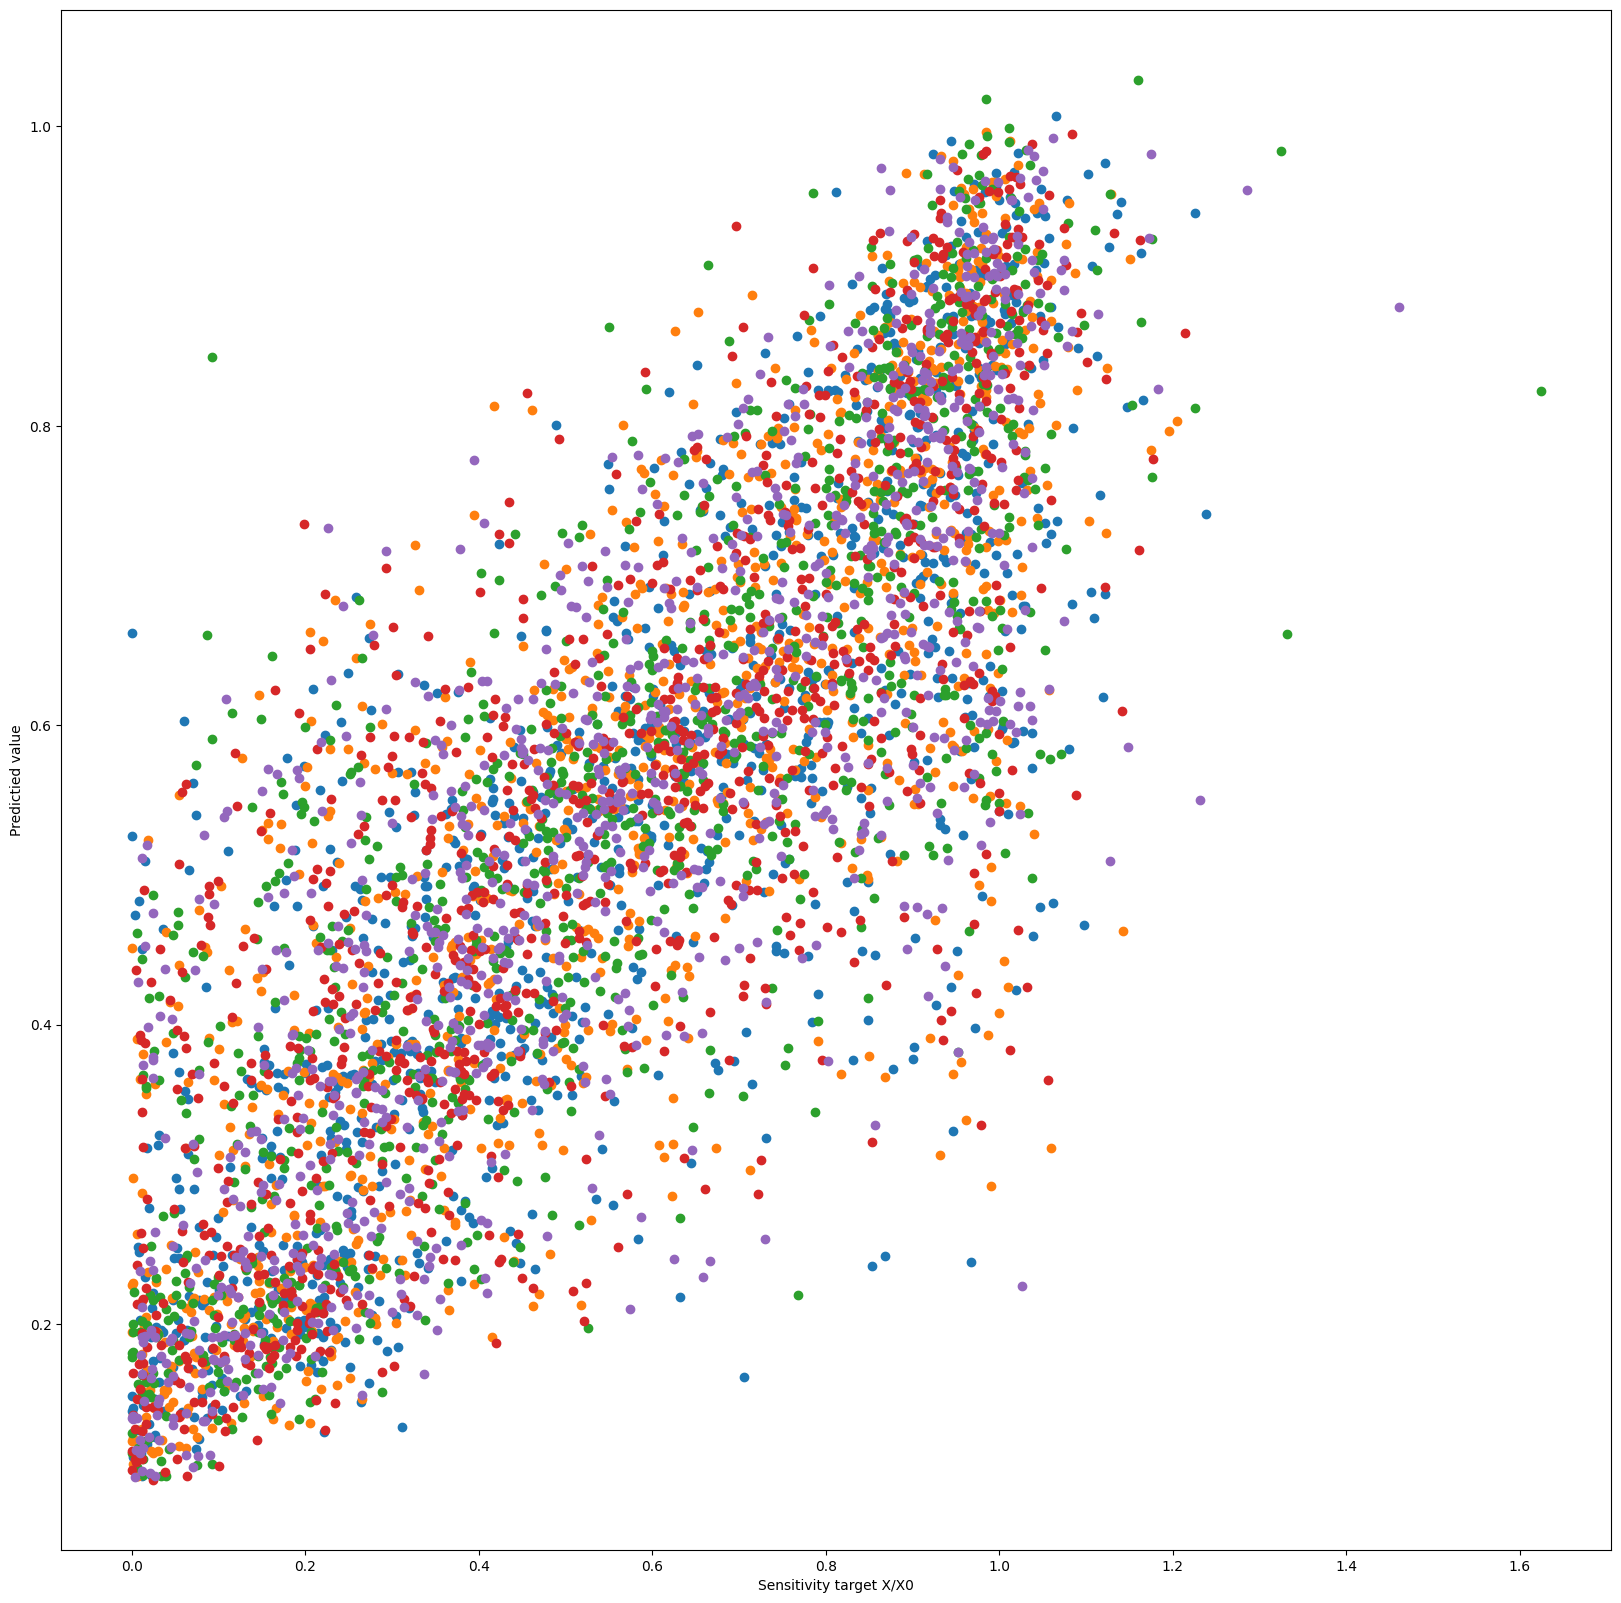

In [6]:
batch_size=1024
val_set = Dataset_from_pd(df_val, drug_data, cell_data)
val_dl = DataLoader(val_set, batch_size=batch_size)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot()
model.eval()
model.to(device)
number = 0
with torch.no_grad():
    for i, data in enumerate(val_dl):
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        outputs = model(inputs)
        ax.scatter(labels.view(-1).to("cpu").numpy(), outputs.view(-1).to("cpu").numpy())
        ax.set_xlabel("Sensitivity target X/X0")
        ax.set_ylabel("Predictied value")

        number += labels.view(-1).shape[0]
        if i==4:break
plt.show()
#         loss_test = loss_fn(outputs, labels).item()
#         mae_test = mae_fn(outputs, labels).item()
#         vx = voutputs - torch.mean(outputs)
#         vy = vlabels - torch.mean(labels)
#         pcc_test = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2))).item()
# print([avg_vloss, avg_MAE, avg_PCC, loss_test, mae_test, pcc_test])
# L.append([avg_vloss, avg_MAE, avg_PCC, loss_test, mae_test, pcc_test, outputs.to("cpu").numpy().reshape(-1)])

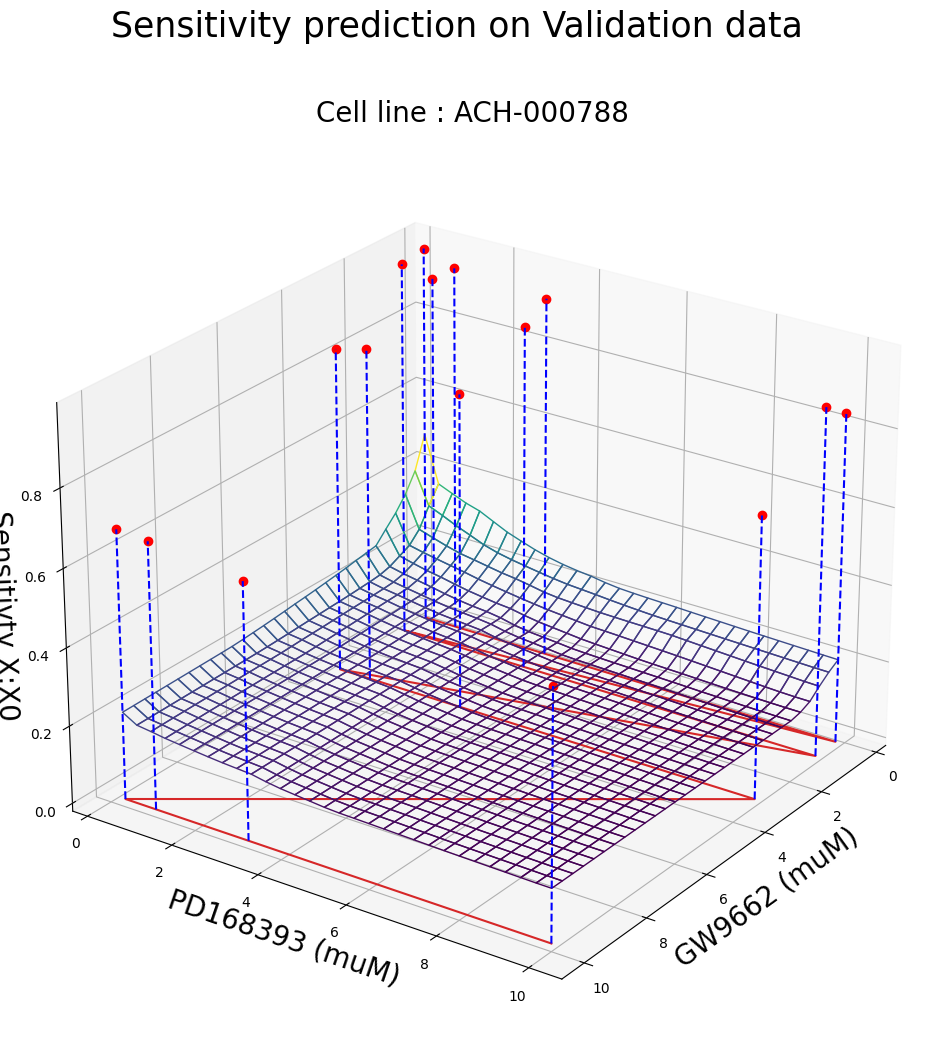

In [19]:
unique_pairs = data_train.loc[:,["drugA_name","drugB_name"]].drop_duplicates()
_, val_unique_pairs = train_test_split(unique_pairs, test_size=0.2, random_state=42)
for i in range(len(val_unique_pairs)):
    cols = unique_pairs.iloc[i].str.cat(sep=" + ")
    df_val = data_train[data_train.drugA_name.str.cat(data_train.drugB_name, sep= " + ").isin([cols])]
    unique_cell_lines_in_comb = df_val.cell_line.drop_duplicates()
    for j in range(len(unique_cell_lines_in_comb)):
        plot_values = df_val[df_val.cell_line==unique_cell_lines_in_comb.iloc[j]]
        plot_values.loc[:,"drugB_name"] = "PD168393"
        plot_values.loc[:,"drugA_name"] = "GW9662"
        # print(plot_values)
        plot_from_df(plot_values, model, device, drug_data, cell_data, title="Sensitivity prediction on Validation data" )
        if j==0:break
    if i==0:break 

plt.show()

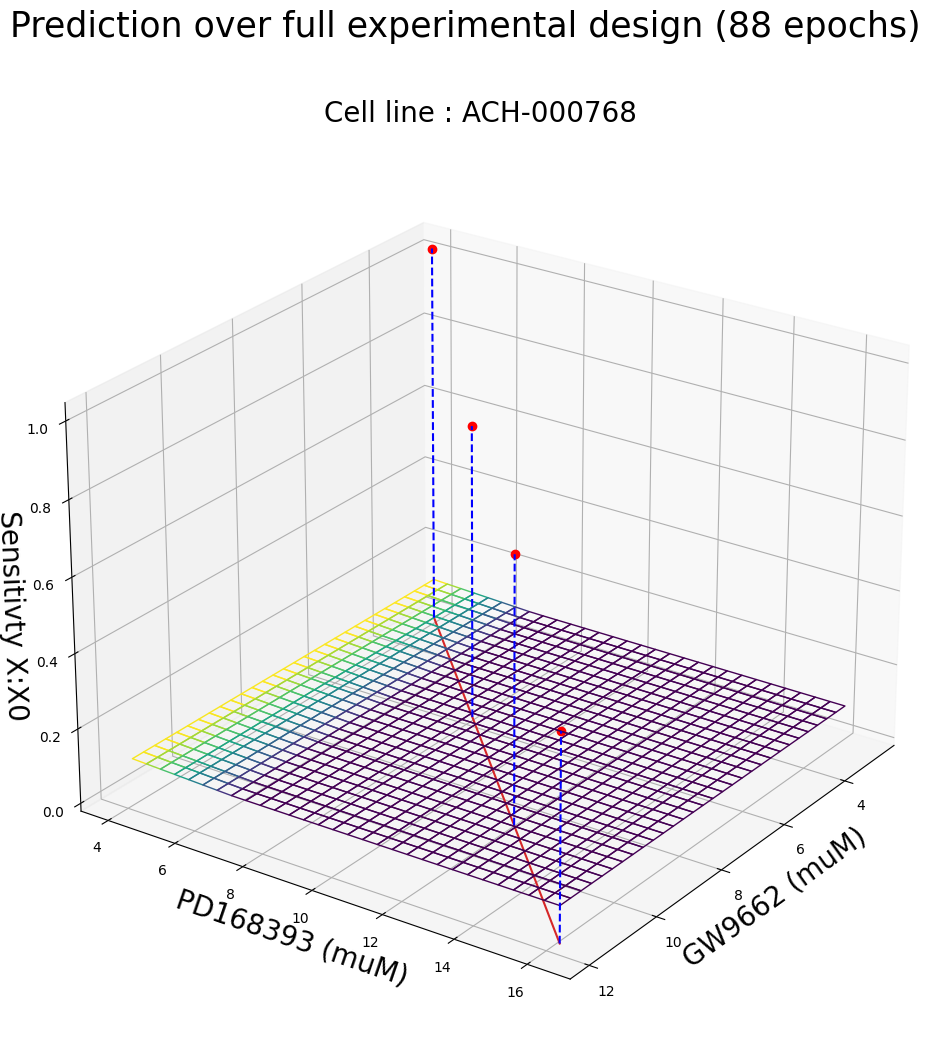

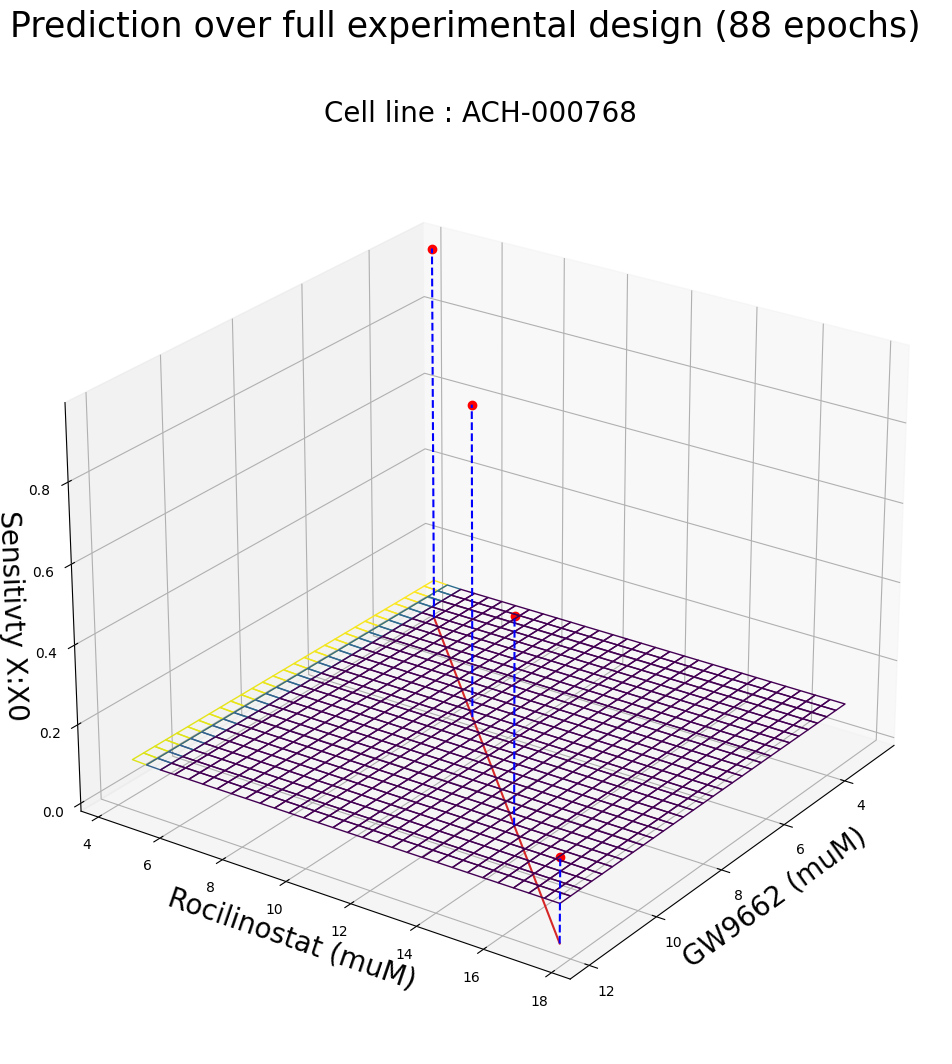

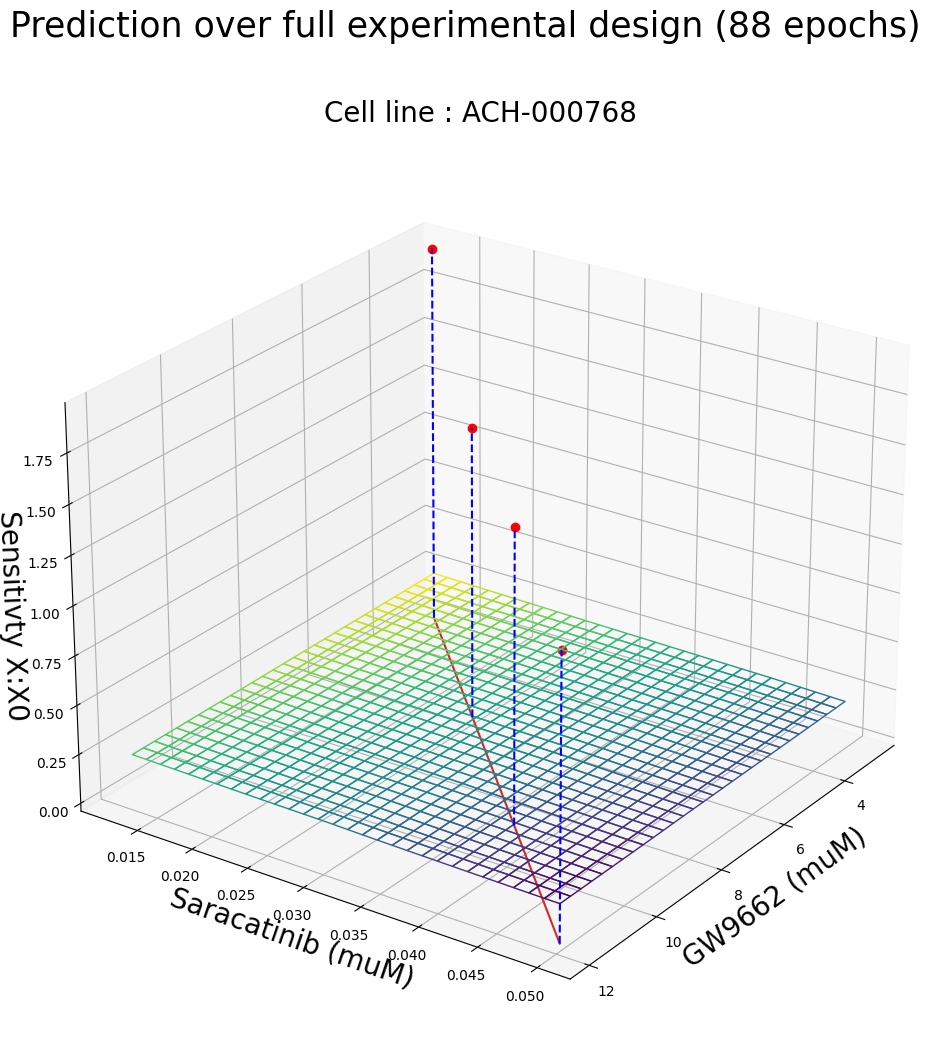

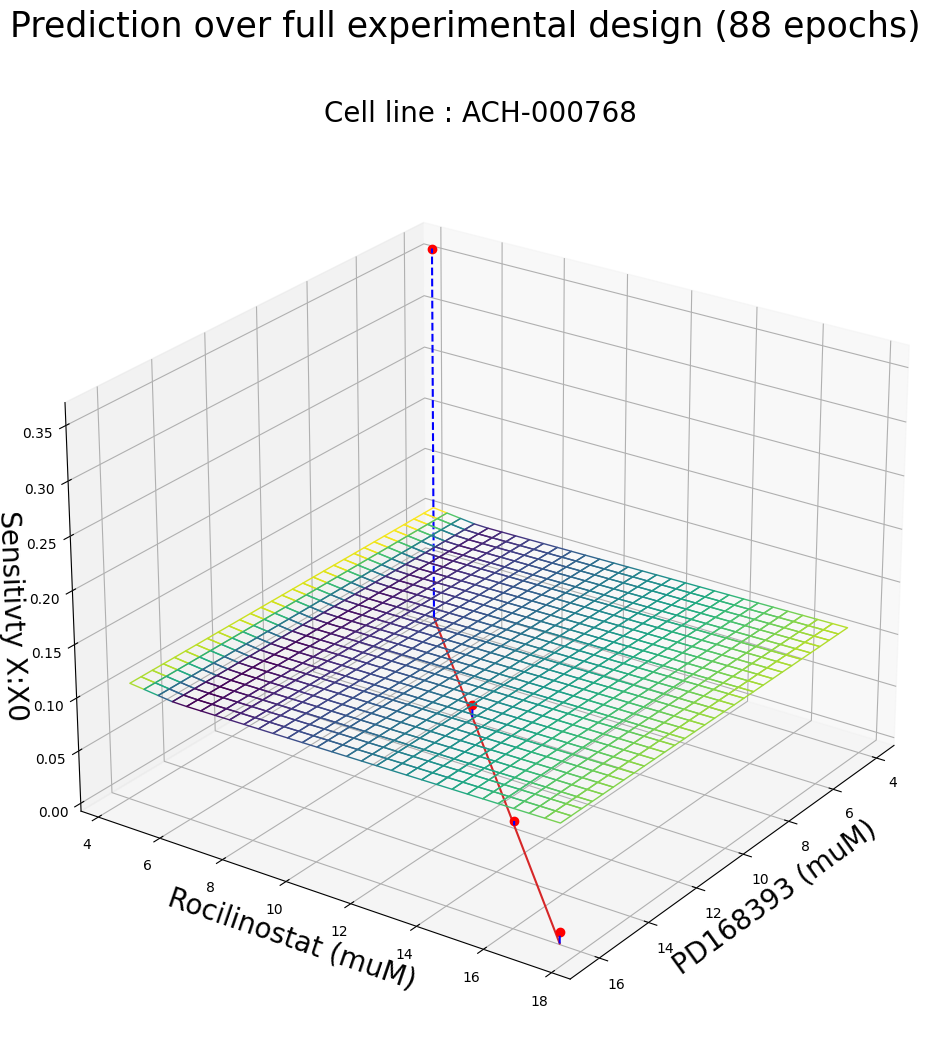

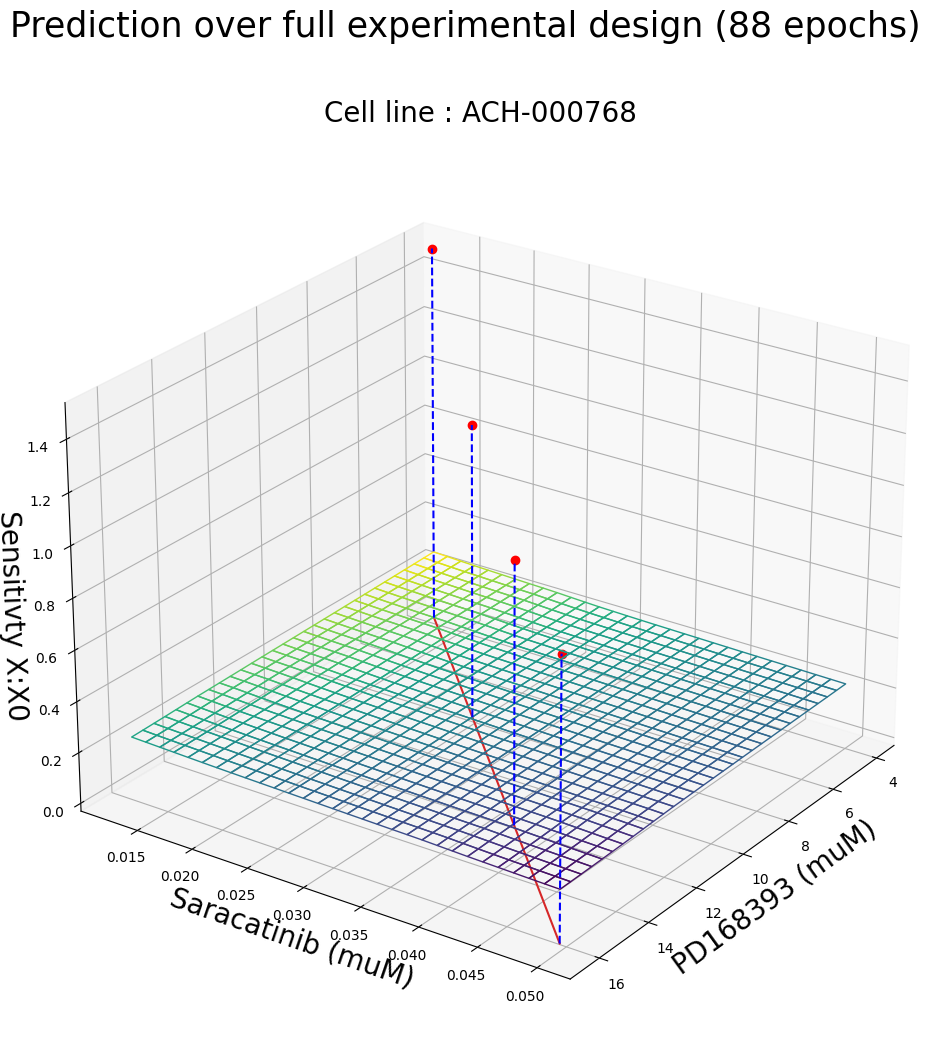

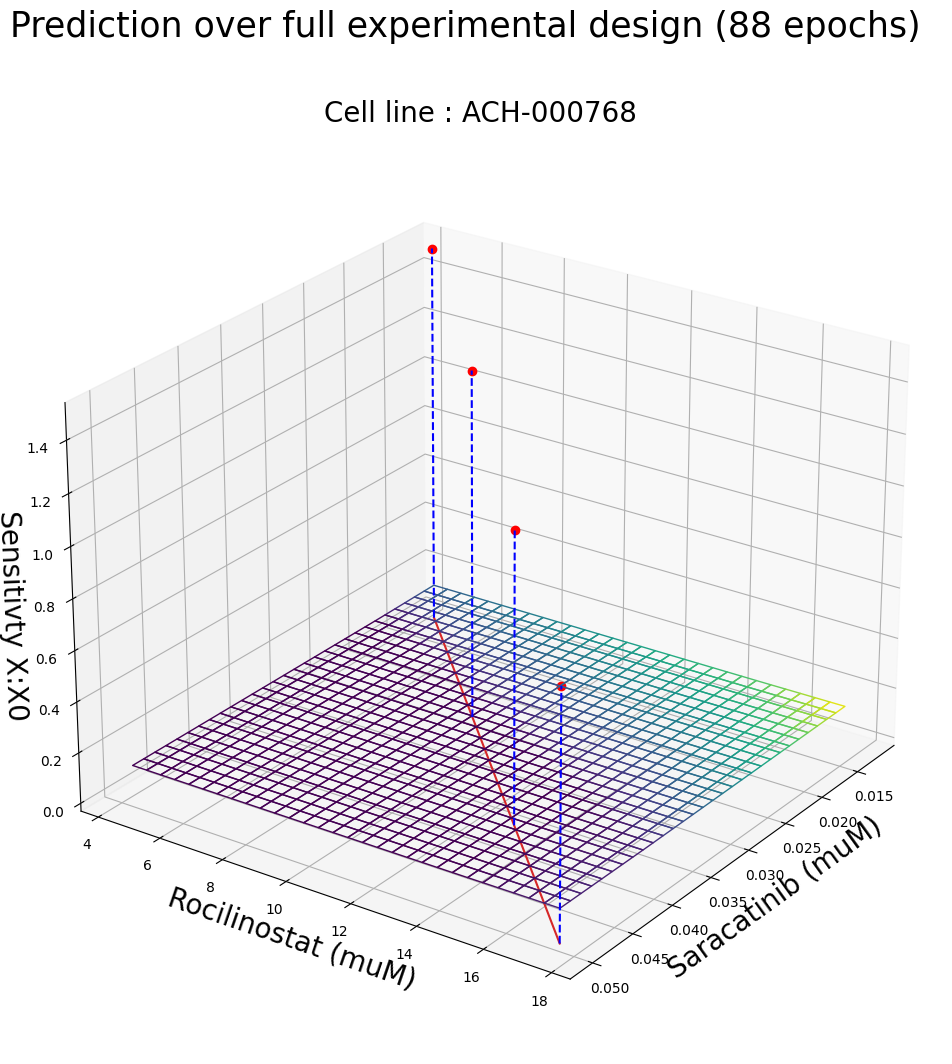

In [20]:
ssize = 30
for i in range(6):
    data = df_test.iloc[4*i:4*(i+1)]
    # print(data)
    plot_from_df(data, model, device, drug_data, cell_data)
plt.show()